In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

### Storing the graph with elevation

In [ ]:
# graph = ox.graph_from_place("Ottawa, Ontario, Canada", "bike")

# graph = ox.elevation.add_node_elevations_google(graph, api_key=API_KEY)
# graph = ox.elevation.add_edge_grades(graph)

# filepath = "./data/ottawa_bike_elevation.graphml"
# ox.save_graphml(graph, filepath)  

### Load the graph and create impedance

In [ ]:
# fetching graph
graph = ox.load_graphml("./data/ottawa_bike_elevation.graphml")

# define some edge impedance function here
def impedance(length, grade):
    penalty = grade**2
    return length * penalty

# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for _, _, _, data in graph.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade"])
    data["rise"] = data["length"] * data["grade"]


# Reproject the graph
graph_proj = ox.project_graph(graph)

### Function that gives back a plot with the shortest path

In [4]:
def shortest_path_map(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return map including origins, destinations, shortest path and network
    '''

    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    #edges.plot()
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject start and end nodes
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
     # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.nearest_nodes(graph_proj, orig.geometry.x, orig.geometry.y)
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.nearest_nodes(graph_proj, target.geometry.x, target.geometry.y)
            
            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                return
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='impedance')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']
    
    # Set geometry
    routes = routes.set_geometry('geometry')
        
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    # path_nodes = []
    # for node_id in route:
    #     temp = graph.nodes(data=True)[node_id]
    #     path_nodes.append([temp["y"], temp["x"]])
    
    # print(path_nodes)

    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(16, 10), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin_proj.plot(ax=ax, color='red')
    ax = destination_proj.plot(ax=ax, color='blue')
    ax = routes.plot(ax=ax, linewidth=3, alpha = 0.8, color = 'magenta')
    
    plt.axis('off')
    
    
    return ax

C:\Users\saif9\AppData\Local\Temp\ipykernel_42012\3970923869.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origin.append(destination)
C:\Users\saif9\AppData\Local\Temp\ipykernel_42012\3970923869.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]], ignore_index=True)
C:\Users\saif9\AppData\Local\Temp\ipykernel_42012\3970923869.py:100: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[[45.3487596, -75.7566543], [45.3487403, -75.7566382], [45.3487842, -75.7563921], [45.3488317, -75.7562756], [45.3491206, -75.7558753], [45.3493027, -75.7553545], [45.3481049, -75.7544504], [45.3478714, -75.7550498], [45.3475712, -75.7558207], [45.347491, -75.7560374], [45.3472564, -75.75679], [45.347253, -75.7574527], [45.3472618, -75.757989], [45.3472314, -75.7583932], [45.3470934, -75.7590009], [45.3469557, -75.759407], [45.3468951, -75.759611], [45.345629, -75.7588551], [45.3436687, -75.7576967], [45.3437219, -75.7575041], [45.3440458, -75.7565791], [45.3452496, -75.7535007], [45.3444989, -75.7529235], [45.3437121, -75.7523214], [45.3430699, -75.7518322], [45.3410736, -75.7547933], [45.3424188, -75.7513431], [45.3417604, -75.7508064], [45.340892, -75.7501265], [45.3396666, -75.7533718], [45.339402, -75.7540727], [45.33895, -75.753795], [45.3387798, -75.7509757], [45.3392599, -75.746966], [45.3395675, -75.7437902], [45.3395893, -75.743101], [45.3398957, -75.7402713], [45.3404881, -7

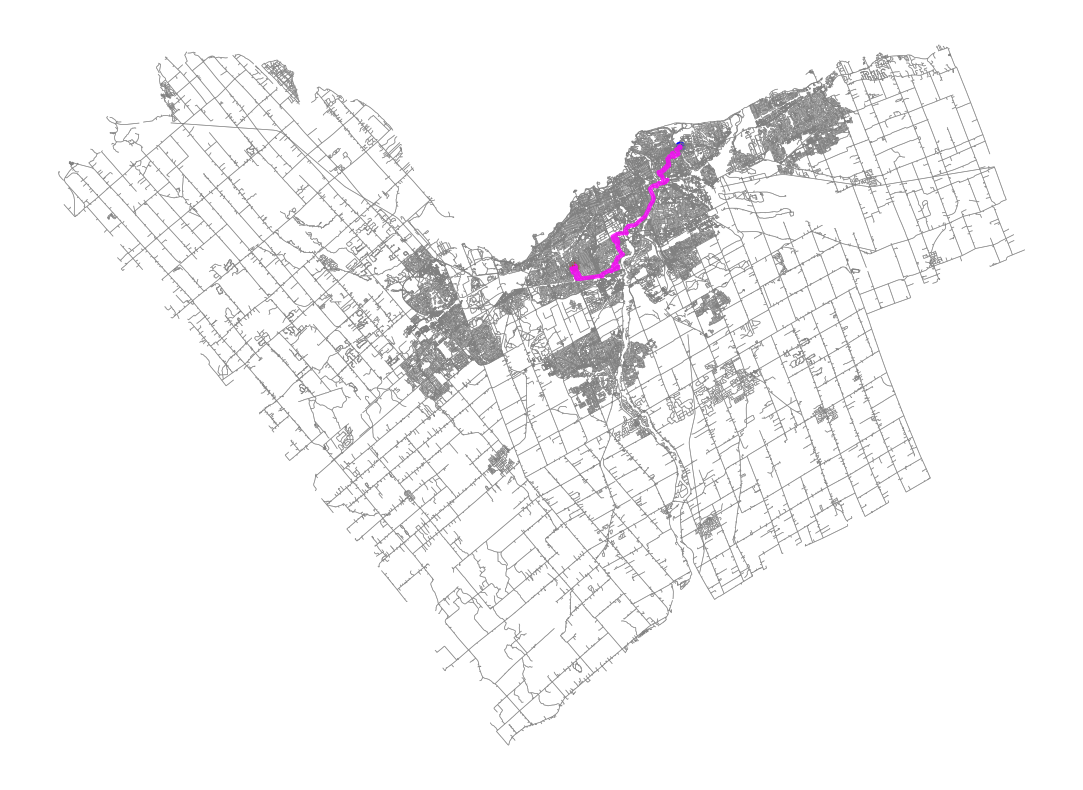

In [5]:
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-75.75723, 45.34900)
origin.at[0, 'name'] = 'Algonquin'

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-75.63844, 45.44515)
destination.at[0, 'name'] = 'Montfort'

shortest_path_map(origin, destination, 'bike')
plt.savefig('cycling_network.png')

### Show Convex Hull Method

In [2]:
def osm_map(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe>, network <str> drive, bike, walk
    return map including origins, destinations, and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    #graph = ox.graph_from_place("Ottawa, Ontario, Canada", "bike")
        
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(14, 8), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin.plot(ax=ax, color='red')
    ax = destination.plot(ax=ax, color='blue')
    
    plt.axis('off')
    
    
    return ax

C:\Users\saif9\AppData\Local\Temp\ipykernel_38336\1683771677.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origin.append(destination)
C:\Users\saif9\AppData\Local\Temp\ipykernel_38336\1683771677.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<AxesSubplot: >

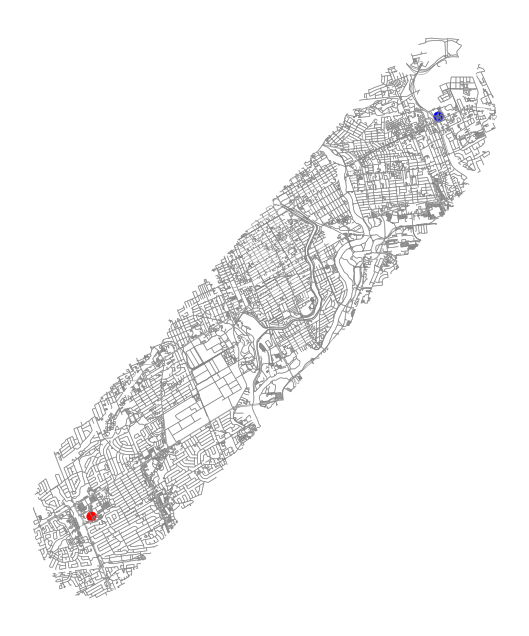

In [3]:
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-75.75723, 45.34900)
origin.at[0, 'name'] = 'Algonquin'

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-75.63844, 45.44515)
destination.at[0, 'name'] = 'Montfort'

osm_map(origin, destination, 'bike')
#plt.savefig('bike_network.png')